In [1]:
import torch
from CNN.models import MlpRegBaseline
from CNN.datasets import Class_Seq_Dataset
from CNN.datasets import load_class_seq_data
import matplotlib.pylab as plt
import sys

/home/daqop/anaconda3/envs/deeprank/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# useful functions:
def renorm(data, mean, std):
    data = torch.logit(data)
    data = data*std+mean
    return torch.log(data)


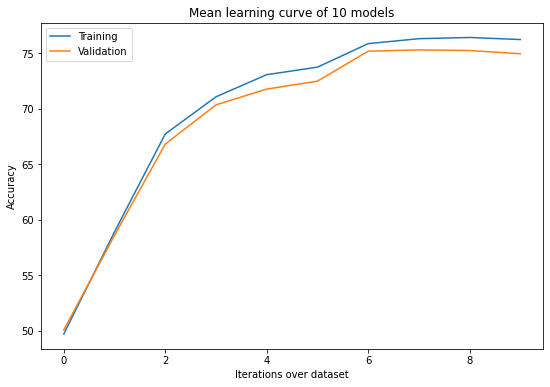

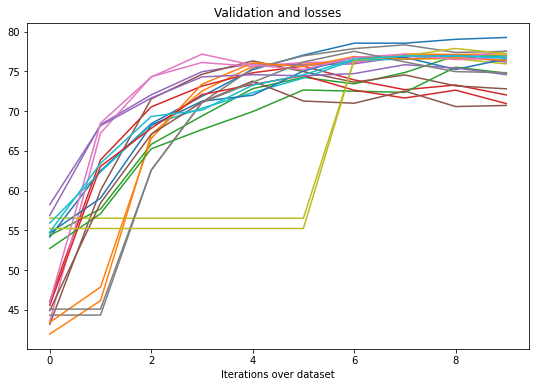

In [2]:
# models_path = "/home/daqop/Desktop/M2/Internship/python/trained_models/"
# models_path = "/home/daqop/mountpoint_snellius/3D-Vac/src/5_train_models/CNN/I/reg/seq/trained_models/"
models_path = "/home/daqop/train_branch_3D_Vac/src/5_train_models/CNN/I/classification/seq/trained_models/"
model_name = "mlp_class_baseline_5_neurons_10_epochs_clust_test.pt"
models_path = models_path + model_name
cp = torch.load(models_path)
xval_data = cp["models_data"]
a = cp["arguments"]

train_losses = torch.tensor([data["train_losses"] for data in xval_data])
validation_losses = torch.tensor([data["validation_losses"] for data in xval_data])
train_losses = torch.permute(train_losses, (1,0))
validation_losses = torch.permute(validation_losses, (1,0))

#plot mean validation and loss
plt.figure(figsize=(9,6))
plt.plot(range(a.epochs), train_losses.mean(dim=1))
plt.plot(range(a.epochs), validation_losses.mean(dim=1))
plt.title("Valid")
plt.xlabel("Iterations over dataset")
plt.ylabel("Accuracy")
plt.title("Mean learning curve of 10 models")
plt.legend(["Training", "Validation"])
plt.show()

#plot the actual validation and loss
plt.figure(figsize=(9,6))
plt.plot(range(a.epochs), train_losses)
plt.plot(range(a.epochs), validation_losses)
plt.title("Validation and losses")
plt.xlabel("Iterations over dataset")
plt.show()

In [6]:

# plot the r-squared and other metrics for each model
all_indices = []
csv_peptides, csv_ba_values = load_class_seq_data("../../data/binding_data/BA_pMHCI.csv", a.threshold)
dataset = Class_Seq_Dataset(csv_peptides, csv_ba_values, a.encoder)
accuracies = []
for data in xval_data:
    # load the model and data
    model = MlpRegBaseline(neurons_per_layer=a.neurons) 
    model.load_state_dict(data["model"])
    model.eval()

    test_X = dataset.peptides[data["test_indices"]]
    test_label = dataset.labels[data["test_indices"]]

    with torch.no_grad():
        # make the prediction on the test dataset
        test_pred_label = torch.reshape(model(test_X), (-1,))
        accuracy = float((test_pred_label.round() == test_label).sum()/test_label.shape[0])
        accuracies.append(accuracy)
print(torch.tensor(accuracies).mean())

tensor(0.8295)
